In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from bigfile import BigFile
import glob,os,struct
# from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from scipy.interpolate import interp1d
from colossus.cosmology import cosmology
import seaborn as sns

sns.set()
sns.set_palette("Set2")
sns.set_style('ticks',{'ytick.direction':'in','xtick.direction':'in'})

cmap = plt.get_cmap("Set2")
sns.set_context("paper", font_scale=1.7,rc={"axes.linewidth": 1.3,"lines.linewidth": 2.5,"patch.linewidth": 2.2})
from matplotlib import rcParams as rc
import pickle
import warnings
import h5py

/home1/08942/nianyic/anaconda3/lib/python3.9/site-packages/scipy/stats/_ksstats.py:74: RuntimeWarning: invalid value encountered in ldexp
  _EP128 = np.ldexp(np.longdouble(1), _E128)


In [2]:
snap = 483
if snap > 294:
    pig = BigFile('/home1/08942/nianyic/scratch3/Astrid/PIG_483_subfind')
else:
    pig = BigFile('/home1/08942/nianyic/scratch3/Astrid/PIG_483_subfind')

# you can check the redshift by reading the attributes of the snapshot
battr = pig["Header"].attrs
scale_fac = battr["Time"][0]
redshift = 1./battr["Time"][0] - 1
Lbox = battr['BoxSize']
hh = battr['HubbleParam']
om0 = battr['Omega0']
omb = battr['OmegaBaryon']
oml = battr['OmegaLambda']
Nfof = battr['NumFOFGroupsTotal']
sigma8 = 0.82
print('----------PIG file info------------')

print('Redshift = %.2f'%redshift)
print('Lbox = %d ckpc/h'%Lbox)
print('NfofGroups = %d'%Nfof)

print('------cosmological parameters-----')
print('h = %.4f'%hh)
print('Omega_m = %.4f'%om0)
print('Omega_b = %.4f'%omb)
print('Omega_l = %.4f'%oml)


----------PIG file info------------
Redshift = 1.30
Lbox = 250000 ckpc/h
NfofGroups = 177398278
------cosmological parameters-----
h = 0.6774
Omega_m = 0.3089
Omega_b = 0.0486
Omega_l = 0.6911


In [3]:
# outdir = '/hildafs/datasets/Asterix/PIG2/PIG_348_subfind'
# pig2 = BigFile(outdir)
pig2 = BigFile('/home1/08942/nianyic/scratch3/Astrid/PIG_483_subfind')

gLength = pig['FOFGroups/LengthByType']
gOffset = pig['FOFGroups/OffsetByType']
dest_r = pig2

gLength = pig2['FOFGroups/LengthByType']
gOffset = pig2['FOFGroups/OffsetByType']
FirstSub = pig2['FOFGroups/GroupFirstSub']

sLength = pig2['SubGroups/SubhaloLenType']
sOffset = pig2['SubGroups/SubhaloOffsetType']
sMass = pig2['SubGroups/SubhaloMassType']

NSubs = pig2['FOFGroups/GroupNsubs']

In [ ]:
gidx = 5
sidx = 

In [3]:
subroot = '/hildafs/datasets/Asterix//subfind/subfind_348'
tab="fof_subhalo_tab_348.hdf5"
grp = "snap-groupordered_348.hdf5"

In [4]:
def get_subfind_chunk(subroot):
    subdir = subroot + '/*'
    
    chunk_list    = []
    maxgroup_list = []
    for ff in sorted(glob.glob(subdir)):
        cname    = ff.split('/')[-1]
        chunk    = int(cname.split('.')[0][5:])
        maxgroup = int(cname.split('.')[1])
        
        chunk_list.append(chunk)
        maxgroup_list.append(maxgroup)
        
    sort  = np.argsort(chunk_list)
    chunk_list    = np.array(chunk_list)[sort]
    maxgroup_list = np.array(maxgroup_list)[sort]
    return chunk_list, maxgroup_list 

In [6]:
chunk_list, maxgroup_list = get_subfind_chunk(subroot)
len(chunk_list)
chunks = chunk_list

In [9]:
BHMass = pig2['5/BlackholeMass'][:]*1e10/hh
bidxlist, = np.where(BHMass > 1e6)

bmass = BHMass[bidxlist]
del BHMass
print(len(bidxlist))

819576


In [10]:
suboff = pig2['SubGroups/SubhaloOffsetType'][:54000000]
suboff5 = suboff[:,5]
del suboff

In [11]:
def place(bidxlist,suboff5):
    sidxlist = np.searchsorted(suboff5,bidx,side='right')-1
    return sidxlist

def get_offset(bidxlist,sidxlist):
    centers = pig2['SubGroups/SubhaloPos'][:54000000][sidxlist]
    dpos = pig2['5/Position'][:][bidxlist] - centers
    dpos[dpos > box/2] -= box
    dpos[dpos < -box/2] += box
    return np.linalg.norm(dpos,axis=1)

In [12]:
box = 250000.
sidxlist = np.searchsorted(suboff5,bidxlist,side='right')-1
print('got sidx')
roff = get_offset(bidxlist,sidxlist)

got sidx


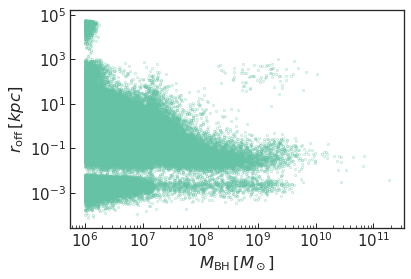

In [13]:
plt.scatter(bmass,roff/3,s=0.1)
plt.xscale('log')
plt.xlabel(r'$M_{\rm BH}\,[M_\odot]$')
plt.ylabel(r'$r_{\rm off}\,[kpc]$')
plt.yscale('log')

## corner case 1: very small offsets

These are cases where the minpot pos is exactly the BH particle?

In [27]:
mask1 = roff < 1e-3
sidxlist1 = sidxlist[mask1]
bidxlist1 = bidxlist[mask1]
print(len(sidxlist1))
# print(sidxlist1)

157


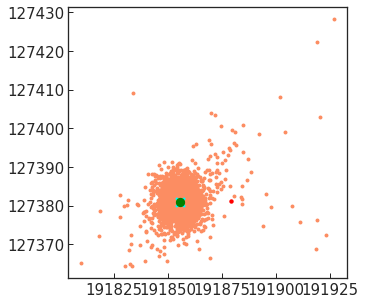

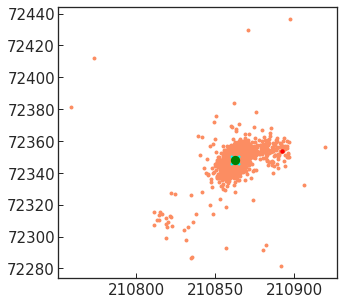

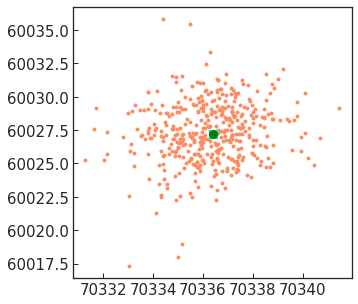

In [28]:
for bidx,sidx in zip(bidxlist1[40:43],sidxlist1[40:43]):
    sstart = sOffset[sidx]
    send   = (sOffset[sidx] + sLength[sidx].astype(np.int64))
    # m1 = sMass[sidx][p]
    # m2 = sum(pig2['%d/Mass'%p][sstart[p]:send[p]])
    # assert np.allclose(m1,m2),"%.1e,%.1e"%(m1,m2)
    # dpos = pig2['1/Position'][sstart[1]:send[1]] 
    # gpos = pig2['0/Position'][sstart[0]:send[0]] 
    spos = pig2['4/Position'][sstart[4]:send[4]] 
    bpos = pig2['5/Position'][sstart[5]:send[5]] 
#     print(pig2['5/SubgroupID'][sstart[5]:send[5]])
    
#     print(bpos)
    target = pig2['5/Position'][bidx] 
    center = pig2['SubGroups/SubhaloPos'][sidx] 

    # print(sidx)
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    # ax[i].scatter(pos[:,0],pos[:,1],s=1,color='grey')

    # ax.scatter(dpos[:,0],dpos[:,1],s=2,color='k')
    # ax.scatter(gpos[:,0],gpos[:,1],s=3,color='b')
    ax.scatter(spos[:,0],spos[:,1],s=3,color=cmap(1))
    ax.scatter(bpos[:,0],bpos[:,1],s=5,color='red')
    ax.scatter(center[0],center[1],color='cyan',marker='x',s=80)
    ax.scatter(target[0],target[1],s=50,color='green')

    # ax.set_title('Group %d Subgroup %d'%(gidx,isub),fontsize=12)
    # ax.set(xticklabels=[],yticklabels=[])
    plt.show()

###

## individual group comparisons

In [5]:
p = 4
for sidx in range(400,410):
    sstart = sOffset[sidx]
    send   = (sOffset[sidx] + sLength[sidx].astype(np.int64))
    # m1 = sMass[sidx][p]
    # m2 = sum(pig2['%d/Mass'%p][sstart[p]:send[p]])
    # assert np.allclose(m1,m2),"%.1e,%.1e"%(m1,m2)
    dpos = pig2['1/Position'][sstart[1]:send[1]] 
    gpos = pig2['0/Position'][sstart[0]:send[0]] 
    spos = pig2['4/Position'][sstart[4]:send[4]] 
    bpos = pig2['5/Position'][sstart[5]:send[5]] 
    print(pig2['5/SubgroupID'][sstart[5]:send[5]])
    
    print(bpos)
    # target = pig2['5/Position'][bidx_trouble[i]] 
    center = pig2['SubGroups/SubhaloPos'][sidx] 

    print(sidx)
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    # ax[i].scatter(pos[:,0],pos[:,1],s=1,color='grey')
    ax.scatter(center[0],center[1],color='cyan',marker='x',s=80)
    ax.scatter(dpos[:,0],dpos[:,1],s=2,color='k')
    ax.scatter(gpos[:,0],gpos[:,1],s=3,color='b')
    ax.scatter(spos[:,0],spos[:,1],s=3,color=cmap(1))
    ax.scatter(bpos[:,0],bpos[:,1],s=5,color='red')
    # ax.scatter(target[0],target[1],s=50,color='green')

    # ax.set_title('Group %d Subgroup %d'%(gidx,isub),fontsize=12)
    # ax.set(xticklabels=[],yticklabels=[])
    plt.show()

NameError: name 'sOffset' is not defined

In [72]:
sidx_bf = BigFile('/hildafs/datasets/Asterix/subfind/subfind-idx/subfind_147')
pig = BigFile('/hildafs/datasets/Asterix/PIG_files/PIG_147')

gLength = pig['FOFGroups/LengthByType']
gOffset = pig['FOFGroups/OffsetByType']

In [91]:
gidx = 20
start,end = gOffset[gidx], gOffset[gidx] + gLength[gidx]
pos5 = pig['5/Position'][start[5]:end[5]]
sidx5 = sidx_bf['5/Subfind-SubGrpIndex2'][start[5]:end[5]]
sidx4 = sidx_bf['4/Subfind-SubGrpIndex2'][start[4]:end[4]]
sidx0 = sidx_bf['0/Subfind-SubGrpIndex2'][start[0]:end[0]]
sidx1 = sidx_bf['1/Subfind-SubGrpIndex2'][start[1]:end[1]]


pos4 = pig['4/Position'][start[4]:end[4]]
pos1 = pig['1/Position'][start[1]:end[1]]
pos0 = pig['0/Position'][start[0]:end[0]]

In [92]:
max(sidx4)

2409

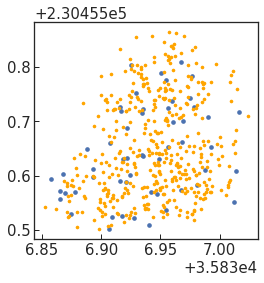

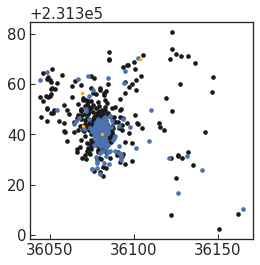

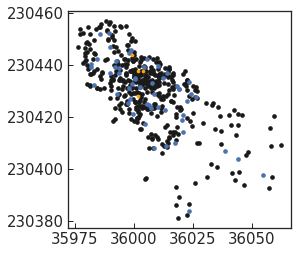

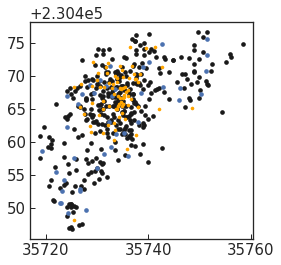

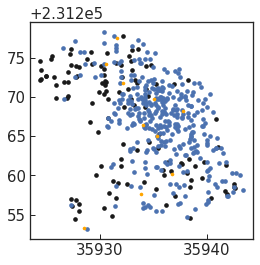

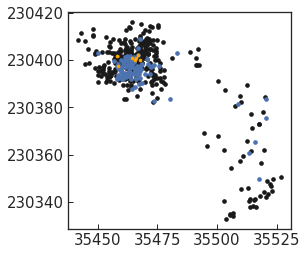

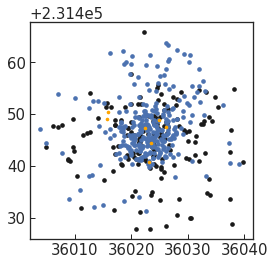

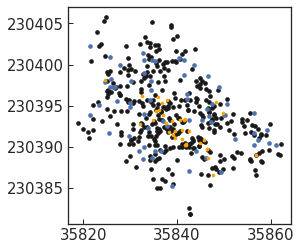

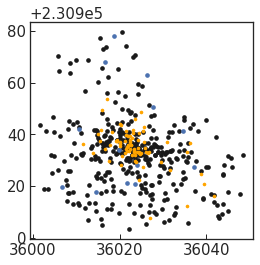

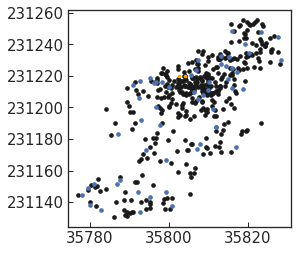

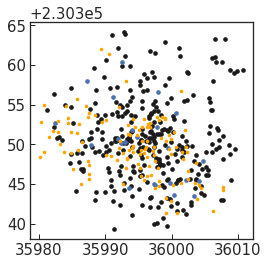

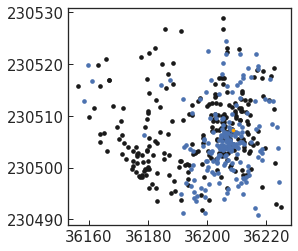

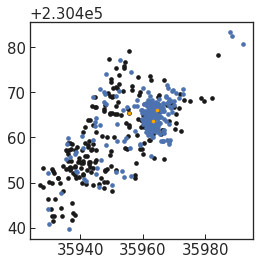

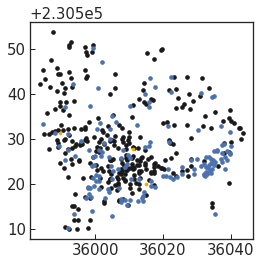

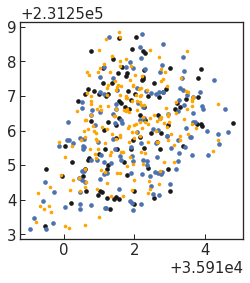

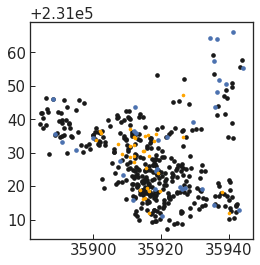

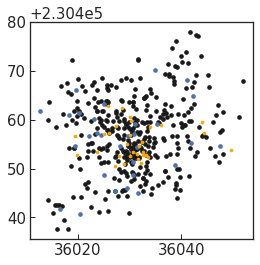

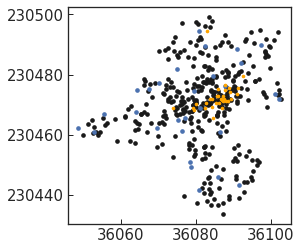

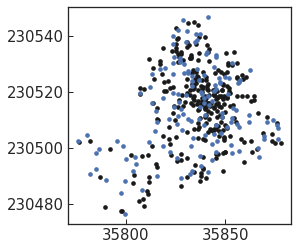

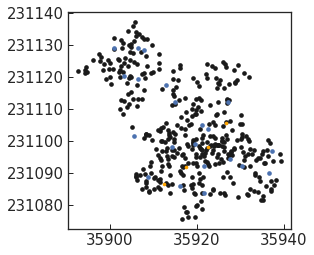

In [93]:
for sidx in range(80, 100):
    mask4 = sidx4==sidx
    mask1 = sidx1==sidx
    mask0 = sidx0==sidx
    
    fig = plt.figure(figsize=(4,4))
    plt.scatter(pos1[mask1,0],pos1[mask1,1],s=6,color='k') 
    plt.scatter(pos0[mask0,0],pos0[mask0,1],s=6,color='b') 
    plt.scatter(pos4[mask4,0],pos4[mask4,1],s=2,color='orange') 
    plt.show()
    

### chunk data

In [161]:
import h5py
snap = 348
grpfile = '/hildafs/datasets/Asterix/subfind/subfind_348/chunk150.151/output/snap-groupordered_%03d.hdf5'%snap
tabfile = '/hildafs/datasets/Asterix/subfind/subfind_348/chunk150.151/output/fof_subhalo_tab_%03d.hdf5'%snap
pos4 = h5py.File(grpfile,'r')['PartType4/Coordinates'][:]
pos1 = h5py.File(grpfile,'r')['PartType1/Coordinates'][:]
glength = h5py.File(tabfile,'r')['Group/GroupLenType'][:]
firstsub = h5py.File(tabfile,'r')['Group/GroupFirstSub'][:]
nsubs = h5py.File(tabfile,'r')['Group/GroupNsubs'][:]
goffset = np.zeros(glength.shape, dtype = np.int64)
goffset[1:] = np.cumsum(glength[:-1], axis=0)
# offset = h5py.File(tabfile,'r')['Subhalo/SubhaloOffsetType'][:]
slength = h5py.File(tabfile,'r')['Subhalo/SubhaloLenType'][:]
soffset = np.zeros(slength.shape, dtype = np.int64)

centers = h5py.File(tabfile,'r')['Subhalo/SubhaloPos'][:]

for g in range(len(nsubs)):
    ff = firstsub[g]
    if ff < 0:
        continue
    soffset[ff] = goffset[g]
    soffset[ff+1 : ff + nsubs[g]] = goffset[g] + np.cumsum(slength[ff : ff + nsubs[g] - 1], axis=0)





In [170]:
18056309/12

1504692.4166666667

In [168]:
for i in range(20):
    print(firstsub[i], nsubs[i])
    print(glength[i])

0 1083
[1910707 2953880       0       0 2817635     398]
1083 1
[199 322   0   0   2   0]
-1 0
[170 127   0   0   1   0]
-1 0
[ 85 185   0   0   0   0]
1084 1
[159  78   0   0   0   0]
-1 0
[ 88 131   0   0   0   0]
-1 0
[46 84  0  0  0  0]
-1 0
[96 25  0  0  0  0]
1085 1
[20 89  0  0  0  0]
-1 0
[67 28  0  0  0  0]
-1 0
[25 58  0  0  0  0]
-1 0
[29 43  0  0  0  0]
-1 0
[48 22  0  0  0  0]
-1 0
[40 28  0  0  0  0]
-1 0
[38 23  0  0  0  0]
-1 0
[28 23  0  0  0  0]
-1 0
[22 27  0  0  0  0]
-1 0
[21 21  0  0  0  0]
-1 0
[23 18  0  0  0  0]
-1 0
[19 19  0  0  1  0]


20
[1687723 2733314       0       0 2749636     177]
[1525 3288    0    0 2633    3]


<Figure size 720x720 with 0 Axes>

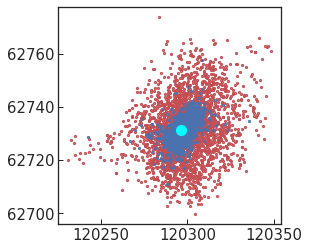

21
[1689248 2736602       0       0 2752269     180]
[   0 2528    0    0 4791    2]


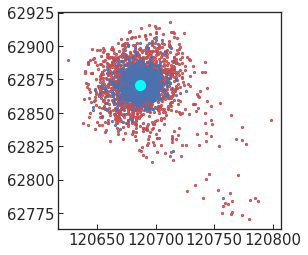

22
[1689248 2739130       0       0 2757060     182]
[2142 2598    0    0 1820    2]


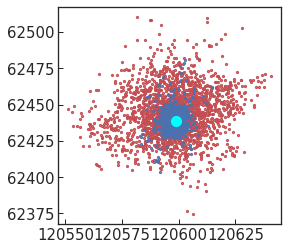

23
[1691390 2741728       0       0 2758880     184]
[2319 2097    0    0 2055    2]


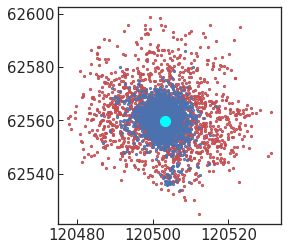

24
[1693709 2743825       0       0 2760935     186]
[2019 2844    0    0 1442    3]


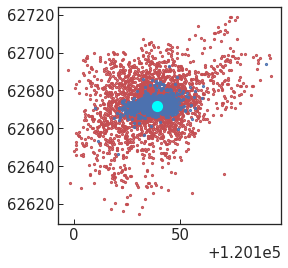

25
[1695728 2746669       0       0 2762377     189]
[3119 2159    0    0  974    1]


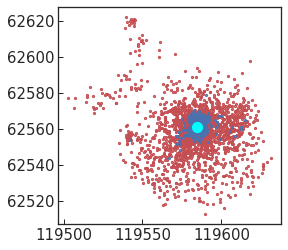

26
[1698847 2748828       0       0 2763351     190]
[1876 2527    0    0  796    1]


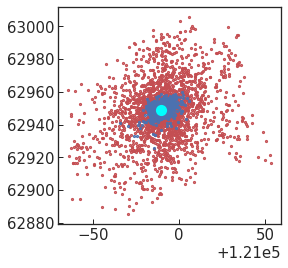

27
[1700723 2751355       0       0 2764147     191]
[   0 2011    0    0 2532    1]


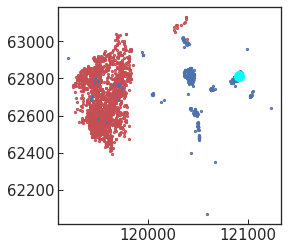

28
[1700723 2753366       0       0 2766679     192]
[1717 1939    0    0  814    1]


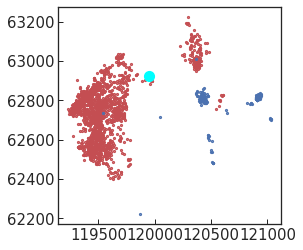

29
[1702440 2755305       0       0 2767493     193]
[   0 1952    0    0 1911    1]


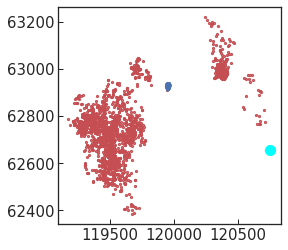

In [166]:
sstart = 20

fig = plt.figure(figsize=(10,10))
# plt.scatter(pos4g[:,0],pos4g[:,1],s=1,color='grey')
for j in range(sstart, sstart+10):
    i = j
    print(j)
    fig = plt.figure(figsize=(4,4))
    beg,end = soffset[i], soffset[i] + slength[i]
    print(beg)
    print(slength[i])
    plt.scatter(pos1[beg[1]:end[1]][:,0],pos1[beg[1]:end[1]][:,1],s=1,color='r')
    plt.scatter(pos4[beg[4]:end[4]][:,0],pos4[beg[4]:end[4]][:,1],s=1,color='b')
    plt.scatter(centers[i,0],centers[i,1],color='cyan',s=80)

    plt.show()

### identify problematic subgroups:

chunk 180: sub43
chunk 182: sub30
chunk 186: sub12 ?????
chunk 198: sub20

chunk200.229: starting from subgroup ~600
chunk 201: subgroup 539
chunk 202:
chunk 214: subgroup 623

chunk 216: second group, sub 1252
chunk 217: 4th group, sub 2140
chunk 218: 3rd group, sub 1650
chunk 219: 
chunk 220: nth group, sub 6850
chunk 223: nth group, sub 4610
chunk 224: None
chunk 225: None

In [119]:
import h5py
snap = 348
grpfile = '/hildafs/datasets/Asterix/subfind/subfind_348/chunk224.955/output/snap-groupordered_%03d.hdf5'%snap
tabfile = '/hildafs/datasets/Asterix/subfind/subfind_348/chunk224.955/output/fof_subhalo_tab_%03d.hdf5'%snap
pos4 = h5py.File(grpfile,'r')['PartType4/Coordinates'][:]
pos1 = h5py.File(grpfile,'r')['PartType1/Coordinates'][:]
glength = h5py.File(tabfile,'r')['Group/GroupLenType'][:]
firstsub = h5py.File(tabfile,'r')['Group/GroupFirstSub'][:]
nsubs = h5py.File(tabfile,'r')['Group/GroupNsubs'][:]
goffset = np.zeros(glength.shape, dtype = np.int64)
goffset[1:] = np.cumsum(glength[:-1], axis=0)
# offset = h5py.File(tabfile,'r')['Subhalo/SubhaloOffsetType'][:]
slength = h5py.File(tabfile,'r')['Subhalo/SubhaloLenType'][:]
soffset = np.zeros(slength.shape, dtype = np.int64)

centers = h5py.File(tabfile,'r')['Subhalo/SubhaloPos'][:]

for g in range(len(nsubs)):
    ff = firstsub[g]
    if ff < 0:
        continue
    soffset[ff] = goffset[g]
    soffset[ff+1 : ff + nsubs[g]] = goffset[g] + np.cumsum(slength[ff : ff + nsubs[g] - 1], axis=0)





In [120]:
for i in range(20):
    print(firstsub[i], nsubs[i])

0 458
458 508
966 505
1471 488
1959 545
2504 457
2961 499
3460 606
4066 432
4498 429
4927 508
5435 522
5957 538
6495 324
6819 478
7297 460
7757 640
8397 466
8863 574
9437 570


In [107]:
firstsub[:20]

array([    0,   520,  1086,  1537,  1904,  2454,  2895,  3389,  3986,
        4501,  5146,  5689,  6208,  6854,  7447,  7931,  8544,  9142,
        9710, 10176], dtype=int32)

In [108]:
nsubs[:20]

array([520, 566, 451, 367, 550, 441, 494, 597, 515, 645, 543, 519, 646,
       593, 484, 613, 598, 568, 466, 535], dtype=int32)

In [44]:
len(soffset)

20792

8390
[16997311 21796860        0        0 17717625     2983]
[ 0 20  0  0  0  0]


<Figure size 720x720 with 0 Axes>

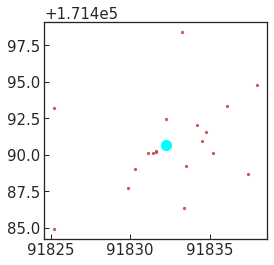

8391
[16997311 21796880        0        0 17717625     2983]
[ 0 19  0  0  1  0]


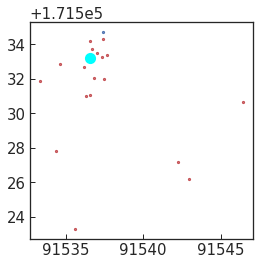

8392
[16997311 21796899        0        0 17717626     2983]
[ 0 20  0  0  0  0]


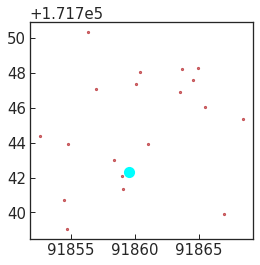

8393
[16997311 21796919        0        0 17717626     2983]
[ 0 20  0  0  0  0]


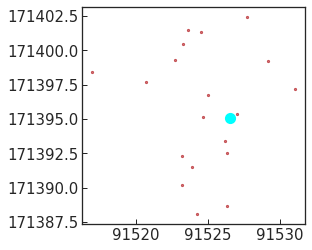

8394
[16997311 21796939        0        0 17717626     2983]
[ 0 20  0  0  0  0]


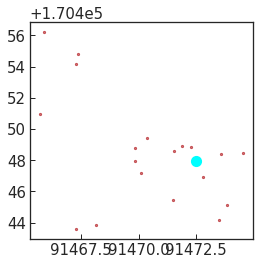

8395
[16997311 21796959        0        0 17717626     2983]
[ 0 20  0  0  0  0]


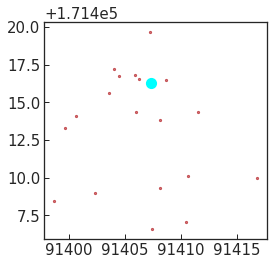

8396
[16997311 21796979        0        0 17717626     2983]
[ 0 20  0  0  0  0]


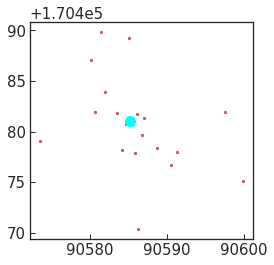

8397
[17203540 22003893        0        0 17718240     2983]
[ 664712  956424       0       0 1028600      63]


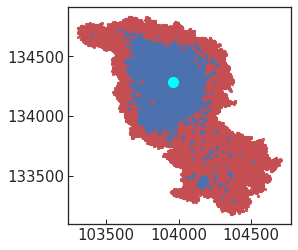

8398
[17868252 22960317        0        0 18746840     3046]
[108767 125710      0      0 164485     13]


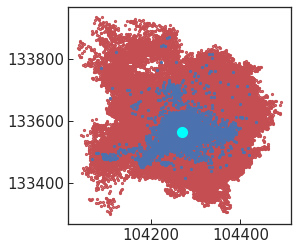

8399
[17977019 23086027        0        0 18911325     3059]
[ 2097  6334     0     0 28361     3]


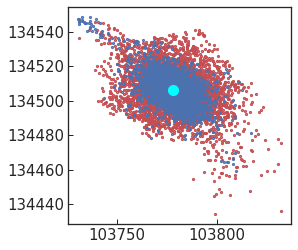

In [121]:
sstart = 8390

fig = plt.figure(figsize=(10,10))
# plt.scatter(pos4g[:,0],pos4g[:,1],s=1,color='grey')
for j in range(sstart, sstart+10):
    i = j
    print(j)
    fig = plt.figure(figsize=(4,4))
    beg,end = soffset[i], soffset[i] + slength[i]
    print(beg)
    print(slength[i])
    plt.scatter(pos1[beg[1]:end[1]][:,0],pos1[beg[1]:end[1]][:,1],s=1,color='r')
    plt.scatter(pos4[beg[4]:end[4]][:,0],pos4[beg[4]:end[4]][:,1],s=1,color='b')
    plt.scatter(centers[i,0],centers[i,1],color='cyan',s=80)

    plt.show()